## Model the redshift errors

In [14]:
import os
import sys
import fitsio
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

sys.path.append('/global/homes/s/shengyu/desi_y3_redshift_errors/main/')
from helper import REDSHIFT_OVERALL, COLOR_OVERALL
from helper import REDSHIFT_VSMEAR, REDSHIFT_LSS_VSMEAR, REDSHIFT_CUBICBOX, COLOR_TRACERS, GET_RECON_BIAS
%load_ext autoreload
%autoreload 2

Z_SMEAR = REDSHIFT_VSMEAR

# save the figure to the overleaf or not
save_fig = True

OVERLEAF_DIR = '/global/homes/s/shengyu/desi_y3_redshift_errors/overleaf/figures'
REPEAT_DIR = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1'
RESULT_DIR = '/global/homes/s/shengyu/desi_y3_redshift_errors/main/repeat_obs/results'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def generate_dv(tracer, zmin, zmax):
    c = 299792.458
    d = Table.read(f'{REPEAT_DIR}/{tracer}repeats.fits', hdu=1)
    sel      = np.full(len(d),True)
    sel = np.isfinite(d['Z1']) & np.isfinite(d['Z2'])
    selz = ((zmin<d["Z1"])&(d["Z1"]<zmax))
    # d_zbin = d[sel]
    d_zbin = d[sel & selz]
    dv_zbin = (d_zbin['Z2']-d_zbin['Z1'])/(1+d_zbin['Z1'])*c
    return dv_zbin

In [ ]:
tracer = 'QSO'
(zmin, zmax) = REDSHIFT_OVERALL[tracer]
color = COLOR_OVERALL[tracer]

dv = generate_dv(tracer, 0.8, 2.1)

cthr = 10000 if tracer == 'QSO' else 1000
dv_smear = dv[abs(dv) < cthr]
median_dv = np.median(abs(dv))
RMS = np.sqrt(np.mean(dv_smear**2))   
fc= np.mean(abs(dv) >= cthr)*100
print(len(dv), median_dv, RMS, fc)

252633 90.96354368041621 471.2414468029257 0.6056215933785372


/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Model the redshift uncertainty part and redshift catastrophics part

In [ ]:
logdv = np.log10(abs(dv))

-5.151849797155677

## Model the redshift errors

In [6]:
import numpy as np
from scipy.stats import gaussian_kde

def get_kcdf(dv, log_cdf=True, vbin = 100, logvbin=0.05,bw='scott', extend_sigma=0.5, nmax=None):
    """
    Kernel-smoothed CDF (KCDF) for dv.

    Parameters
    ----------
    dv : array-like
        Input dv values (can be signed).
    logvbin : float
        Step size in log scale
    log_cdf : bool
        If True, build the CDF of y = log10(|dv|). If False, build CDF of signed dv.
    bw : str or float
        Bandwidth method for Gaussian KDE ('scott', 'silverman', or scalar factor).
    extend_sigma : float
        Range padding in σ for the linear grid; in log case, padding in log units.
    nmax : int or None
        for the linear case; in log case, padding in log units.

    Returns
    -------
    grid : ndarray
        Grid points (dv for linear case, log10(|dv|) for log case).
    cdf  : ndarray
        KCDF values on the grid (monotonic from ~0 to ~1).
    F    : callable
        Interpolator F(x): returns CDF at arbitrary x (same domain as grid).
    """
    v = np.asarray(dv, float)
    v = v[np.isfinite(v)]
    mu, sig = v.mean(), v.std()
    # Optional subsampling for speed
    if nmax is not None and len(v) > nmax :
        v = np.random.choice(v, size=nmax, replace=False)
    # return the logdv distribution
    if log_cdf:
        v = np.abs(v)
        v = v[v > 0]
        y = np.log10(v)
        vmin = y.min()- extend_sigma*np.log10(sig)
        vmax = y.max() + extend_sigma*np.log10(sig)
        edges = np.arange(vmin, vmax + logvbin, logvbin)
    else:
        y = v
        vmin = y.min() - extend_sigma * sig
        vmax = y.max() + extend_sigma * sig
        edges = np.arange(vmin, vmax + vbin, vbin)
    # caluculate the CDF
    grid = 0.5 * (edges[1:] + edges[:-1])
    kde   = gaussian_kde(y, bw_method=bw)
    pdf   = kde(grid)
    # Normalize and integrate
    w = np.diff(edges)
    print(edges)
    print(w)
    pdf /= np.sum(pdf * w)
    cdf = np.cumsum(pdf * w)
    # handy interpolator for F_y(y0)
    F = lambda y: np.clip(np.interp(y, grid, cdf, left=0, right=1), 0, 1)
    return grid, pdf, cdf, F

In [8]:
grid, pdf, cdf, F = get_kcdf(dv, log_cdf=True)

[-7.20131232e+00 -7.15131232e+00 -7.10131232e+00 -7.05131232e+00
 -7.00131232e+00 -6.95131232e+00 -6.90131232e+00 -6.85131232e+00
 -6.80131232e+00 -6.75131232e+00 -6.70131232e+00 -6.65131232e+00
 -6.60131232e+00 -6.55131232e+00 -6.50131232e+00 -6.45131232e+00
 -6.40131232e+00 -6.35131232e+00 -6.30131232e+00 -6.25131232e+00
 -6.20131232e+00 -6.15131232e+00 -6.10131232e+00 -6.05131232e+00
 -6.00131232e+00 -5.95131232e+00 -5.90131232e+00 -5.85131232e+00
 -5.80131232e+00 -5.75131232e+00 -5.70131232e+00 -5.65131232e+00
 -5.60131232e+00 -5.55131232e+00 -5.50131232e+00 -5.45131232e+00
 -5.40131232e+00 -5.35131232e+00 -5.30131232e+00 -5.25131232e+00
 -5.20131232e+00 -5.15131232e+00 -5.10131232e+00 -5.05131232e+00
 -5.00131232e+00 -4.95131232e+00 -4.90131232e+00 -4.85131232e+00
 -4.80131232e+00 -4.75131232e+00 -4.70131232e+00 -4.65131232e+00
 -4.60131232e+00 -4.55131232e+00 -4.50131232e+00 -4.45131232e+00
 -4.40131232e+00 -4.35131232e+00 -4.30131232e+00 -4.25131232e+00
 -4.20131232e+00 -4.15131

In [ ]:
w = np.diff(grid)

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.

In [41]:
(1-F(4))*100

0.60165470479836

In [ ]:
median = np.interp(0.5, cdf, v)
median

20.54493942726498

## Selection effects, bins effect

In [52]:
import numpy as np
from scipy.stats import gaussian_kde

v = np.abs(dv)
v = v[np.isfinite(v) & (v>0)]

# --- Baselines ---
# ECDF (binless)
v_sort = np.sort(v)
ecdf_y = np.arange(1, len(v_sort)+1) / len(v_sort)

# KDE (binless) on a common log grid
xmin, xmax = np.percentile(v, [0.1, 99.9])
x = np.logspace(np.log10(xmin), np.log10(xmax), 2000)
kde = gaussian_kde(np.log10(v))  # KDE in log-space is often better for heavy tails
pdf_kde_log = kde(np.log10(x)) / (x*np.log(10))  # change-of-variables to density in x
pdf_kde = pdf_kde_log
dx = np.diff(x); xm = 0.5*(x[1:]+x[:-1])

def js_divergence(p, q):
    p = p / (p.sum() + 1e-30)
    q = q / (q.sum() + 1e-30)
    m = 0.5*(p+q)
    kl = lambda a,b: np.sum(np.where(a>0, a*np.log((a+1e-30)/(b+1e-30)), 0.0))
    return 0.5*kl(p,m) + 0.5*kl(q,m)

records = []
# nbins_list = [30, 50, 80, 120, 180, 250]  # try a sweep
nbins_list = np.linspace(20, 200, 20, dtype=int)

for nb in nbins_list:
    edges = np.logspace(np.log10(xmin), np.log10(xmax), nb+1)
    counts, edges = np.histogram(v, bins=edges)
    widths = np.diff(edges)
    pdf = counts / (counts.sum() * widths)
    cdf = np.cumsum(pdf * widths)

    # interpolate binned CDF to ECDF x-grid (v_sort) to get KS distance
    cdf_x = 0.5*(edges[1:]+edges[:-1])
    cdf_interp = np.interp(v_sort, cdf_x, cdf, left=0, right=1)
    ks = np.max(np.abs(cdf_interp - ecdf_y))

    # compare PDF to KDE on common midpoints xm
    pdf_hist_on_x = np.interp(xm, cdf_x, pdf)
    # normalize on xm grid to avoid edge leakage differences
    pdf_hist_on_x = pdf_hist_on_x / (np.sum(pdf_hist_on_x*dx) + 1e-30)
    pdf_kde_on_x  = pdf_kde[:-1] / (np.sum(pdf_kde[:-1]*dx) + 1e-30)

    jsd = js_divergence(pdf_hist_on_x*dx, pdf_kde_on_x*dx)  # compare as discrete pmfs on xm

    # stability of key metrics
    fc_thr = 10000 if tracer == 'QSO' else 1000  # or 10000 for QSO
    fc_hist = np.trapz(pdf[cdf_x>=fc_thr], cdf_x[cdf_x>=fc_thr])
    p50 = np.interp(0.5, cdf, cdf_x)   # median
    p90 = np.interp(0.9, cdf, cdf_x)

    records.append((nb, ks, jsd, fc_hist, p50, p90))

# records now shows how KS/JSD and metrics vary with nbins

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


In [53]:
columns = ['nbins', 'KS', 'JSD', 'fc_hist', 'p50', 'p90']
df = pd.DataFrame(records, columns=columns)
print(df)

    nbins        KS       JSD   fc_hist        p50         p90
0      20  0.084742  0.002961  0.003678  70.470643  430.960343
1      29  0.062945  0.000728  0.004083  74.902690  429.845731
2      38  0.049752  0.000316  0.004265  77.686601  434.254409
3      48  0.040451  0.000109  0.004650  79.235268  454.666690
4      57  0.034760  0.000078  0.004675  81.039789  457.952628
5      67  0.029952  0.000090  0.004792  82.312718  468.480638
6      76  0.026247  0.000065  0.004787  83.129040  470.951364
7      86  0.023301  0.000088  0.004774  84.107921  476.998961
8      95  0.021274  0.000154  0.004772  84.684904  479.141822
9     105  0.019382  0.000144  0.004766  85.188848  483.295083
10    114  0.018188  0.000178  0.004766  85.602726  484.755144
11    124  0.017198  0.000161  0.004760  85.932157  487.721284
12    133  0.015621  0.000207  0.004767  86.289430  488.867983
13    143  0.014350  0.000279  0.004758  86.615055  490.917587
14    152  0.013933  0.000295  0.004757  86.848199  491

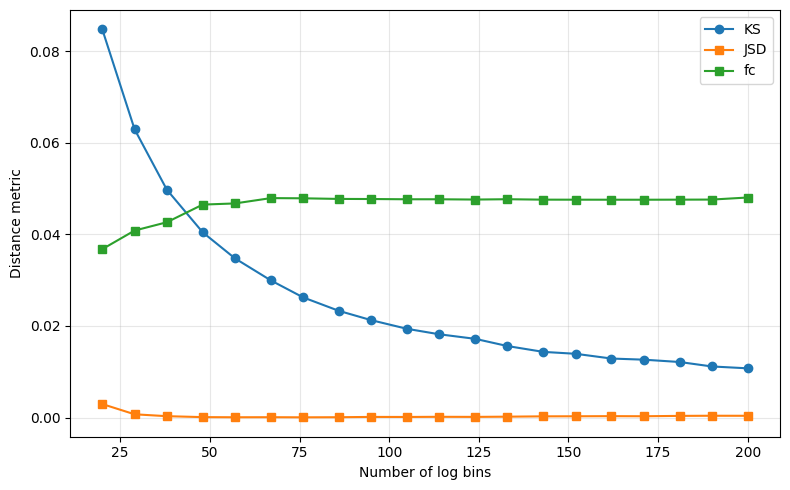

In [ ]:
nbins, KS, JSD, fc_hist, p50, p90 = map(np.array, zip(*records))

fig, ax1 = plt.subplots(figsize = (8,5))
ax1.plot(nbins, KS, 'o-', label='KS')
ax1.plot(nbins, JSD, 's-', label='JSD')
ax1.plot(nbins, fc_hist*5, 's-', label='fc')
# ax1.set_xscale('log')
ax1.set_xlabel('Number of log bins')
ax1.set_ylabel('Distance metric')
ax1.legend(); ax1.grid(alpha=0.3)
plt.tight_layout(); plt.show()

In [ ]:
def vsmear_modelling(tracer,zmin,zmax,dvfn='./'):
    """
    vsmear_modelling function:

    This function provide the probability distribution function (PDF) and the cumulative probability function (CDF) \
    of the redshift difference Delta_v from repeated observations of DESI Y3 tracers (e.g., LRG, ELG, QSO, BGS) \
    at a given redshift range [zmin, zmax]. This is to prepare for applying them to the mocks.

    Parameters:
    ----------
    - tracer : str
        The tracer type. Valid values are 'LRG', 'ELG', 'QSO', and 'BGS' or their subsamples.
    
    - zmin : float
        The minimum redshift of the range to be considered for selection.
    
    - zmax : float
        The maximum redshift of the range to be considered for selection.
    
    - dvfn : str, optional
        The directory path to store the output files (default is './').

    Returns:
    --------
    This function does not return any values but saves output to files in the specified directory (dvfn).
        - The PDF and CDF of DV for the specified redshift range are saved as `.npz` files.


    Example usage:
    --------------
    vsmear_modelling('LRG', 0.4, 0.6, dvfn='./output')
    """

    from desitarget.targetmask import desi_mask, bgs_mask
    from desitarget.targetmask import zwarn_mask as zmtl_zwarn_mask

    # Validate the tracer input
    
    d     = Table.read(repeatdir)
    # Set parameters for the selection and calculation process
    catasmin, catasmax, catasbin = -3, 6, 0.2
    goodkey = f"GOOD_{tracer[:3]}"
    if tracer == "QSO":
        catasmin = -2
    # Redrock redshift selections:
    # cut on redshift range

    dv_final = np.log10(abs(d['DV'][sel&selz]))  
    
    # provide the Delta_velocity distributions
    dens,bins = np.histogram(dv_final,bins=np.arange(catasmin,catasmax,catasbin),density=True)
    ## keep none-zero elements
    sel_clean = dens>0
    vmid      = (bins[1:]+bins[:-1])/2
    vmid      = vmid[sel_clean]
    ## save the observed PDF and CDF
    cdffn_data= f'{dvfn}/{tracer[:3]}_z{zmin:.1f}-{zmax:.1f}_CDF'
    if not os.path.exists(cdffn_data+'.npz'):       
        vbin_fine = 0.005
        dens_fine,bins_fine=np.histogram(dv_final,bins=np.arange(catasmin,catasmax,vbin_fine),density=True)
        cdf_data     = np.cumsum(dens_fine) * vbin_fine 
        np.savez(cdffn_data, vbin=(bins_fine[1:]+bins_fine[:-1])/2, pdf=dens_fine, cdf=cdf_data)    
    # interpolation for the observed Delta_v distribution
    vnewbin = 0.005
    vnew    = np.arange(vmid[0]-catasbin/2,vmid[-1]+catasbin/2+0.01,vnewbin)
    vnewmid = (vnew[1:]+vnew[:-1])/2
    kernel  = 0.3
    ## compute the modelled PDF and CDF and save them
    cdffn= f'{dvfn}/{tracer[:3]}_z{zmin:.1f}-{zmax:.1f}_kernel{kernel}_CDF'
    if not os.path.exists(cdffn+'.npz'):       
        interp  = gaussian_kde(dv_final, bw_method=kernel)
        pdf     = interp(vnewmid)
        cdf     = np.cumsum(pdf) * vnewbin  
        np.savez(cdffn, vbin=vnewmid, pdf=pdf, cdf=cdf)
    return 0


